## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [14]:
from ipyleaflet import (
    Map, Layout,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [15]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [16]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[3]) created by __init__ at <ipython-input-4-9a9c5a5dabc7>:6 

In [17]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [18]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSBSSSBB'
meas='PRCP'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
2826
+------------------+------------------+-------------------+---------+--------+--------+---------+------------------+-----------+------------------+-------------------+-------------------+------------------+-----------+---------+------+--------------------+------+
|           coeff_1|           coeff_2|            coeff_3|elevation|   label|latitude|longitude|        mean_value|measurement|             res_1|              res_2|              res_3|          res_mean|    station|total_var|undefs|              vector|  year|
+------------------+------------------+-------------------+---------+--------+--------+---------+------------------+-----------+------------------+-------------------+-------------------+------------------+-----------+---------+------+--------------------+------+
|180.23655028420382| 1257.757097475328| -278.2956462462347|     76.2|BSBSSSBB| 31.8878| -82.5808| 35.32686980609418|       PRCP|0.989

In [19]:
#extract longitude and latitude for each station
feature='mean_value'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,mean_value FROM weather
+-----------+--------+---------+---------+------------------+
|    station|latitude|longitude|elevation|        mean_value|
+-----------+--------+---------+---------+------------------+
|USC00094204| 31.8878| -82.5808|     76.2| 35.32686980609418|
|US1GALR0001| 32.4642| -82.9861|     56.7|37.914201183431956|
|US1GALW0005| 30.8112| -83.3432|     67.1|35.610619469026545|
|US1GALR0003| 32.2827| -82.9046|     94.8| 39.23006134969325|
+-----------+--------+---------+---------+------------------+
only showing top 4 rows



In [20]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
print pdf.head(2)
min_lat = df2.rdd.map(lambda row: row.latitude).reduce(lambda x, y: min(x, y))
max_lat = df2.rdd.map(lambda row: row.latitude).reduce(lambda x, y: max(x, y))
min_long = df2.rdd.map(lambda row: row.longitude).reduce(lambda x, y: min(x, y))
max_long = df2.rdd.map(lambda row: row.longitude).reduce(lambda x, y: max(x, y))
print min_lat, max_lat, min_long, max_long

        station  latitude  longitude  elevation  count(station)  \
40  US1FLBK0002   30.2447   -82.1224       29.9               1   
89  US1FLBK0003   30.3212   -82.2757       40.2               5   

    avg(mean_value)  
40        36.336111  
89        29.188621  
30.1853 33.3256 -83.4681 -82.0314


In [21]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#800000'

## Map

In [22]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)
m.layout = Layout(height = '800px')
r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=1, fill_opacity=1,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

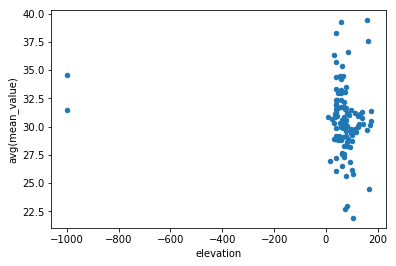

In [23]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(mean_value)');

In [11]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

['spark big  data analysis', 'spring', 'spark  basics']